# Landsat LAI Example - Static

In [1]:
import pprint

import ee
from IPython.display import Image

import openet.lai.landsat

In [2]:
ee.Initialize()

In [3]:
landsat_id = 'LC08_044033_20170716'  # pytest scene
#landsat_id = 'LC08_042034_20180705'  # Clear

In [4]:
image_size = 768

In [5]:
viridis = ['#440154', '#433982', '#30678D', '#218F8B', '#36B677', '#8ED542', '#FDE725']
ndvi_palette = ['EFE7E1', '003300']

In [16]:
landsat_img = ee.Image(f'LANDSAT/{landsat_id[:4].upper()}/C02/T1_L2/{landsat_id.upper()}')

dy = 0.06
xy = landsat_img.geometry().centroid().getInfo()['coordinates']
study_area = ee.Geometry.Rectangle(xy[0] - dy * 2, xy[1] - dy, xy[0] + dy * 2, xy[1] + dy)
region = study_area.bounds(1, 'EPSG:4326')
crs = landsat_img.select('SR_B3').projection().getInfo()['crs']

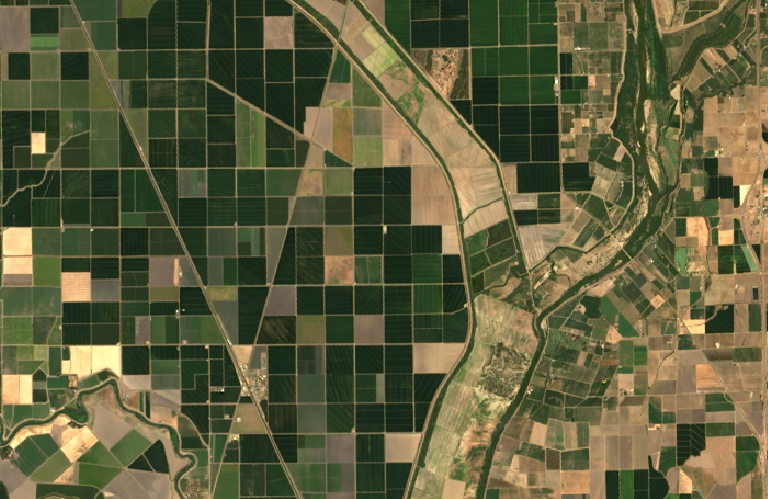

In [17]:
image_url = (
    landsat_img.select([3, 2, 1]).multiply(0.0000275).add(-0.2)
    .getThumbURL({'min': 0.0, 'max': 0.25, 'gamma': 1.25, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

## Prepare the Landsat image for computing LAI

This primarily consists of standardizing the band names.

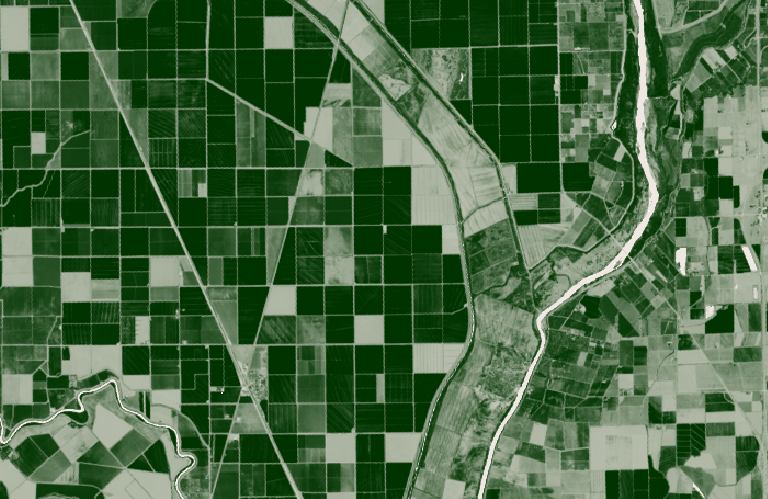

In [18]:
# "Prep" the Landsat image
# This same functionality is in the Landsat module/class
# Note, the reflectance values are intentionally being scaled by 10000 to
#   match the original Collection 1 SR scaling used in the training
input_bands = ee.Dictionary({
    'LANDSAT_5': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_7': ['SR_B1', 'SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_8': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
    'LANDSAT_9': ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7', 'QA_PIXEL'],
})
output_bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'qa_pixel']
spacecraft_id = ee.String(landsat_img.get('SPACECRAFT_ID'))
prep_img = (
    landsat_img.select(input_bands.get(spacecraft_id), output_bands)
    .multiply([0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 0.0000275, 1])
    .add([-0.2, -0.2, -0.2, -0.2, -0.2, -0.2, 0])
    .divide([0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 1])
    .set({
        'system:index': landsat_img.get('system:index'),
        'system:time_start': landsat_img.get('system:time_start'),
        'system:id': landsat_img.get('system:id'), 
        'SPACECRAFT_ID': spacecraft_id,
        'SOLAR_AZIMUTH_ANGLE': ee.Number(landsat_img.get('SUN_AZIMUTH')),
        'SOLAR_ZENITH_ANGLE': ee.Number(landsat_img.get('SUN_ELEVATION')).multiply(-1).add(90),
    })
)

image_url = (
    prep_img.normalizedDifference(['nir', 'red']).select(['nd'], ['ndvi'])
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

## Run the Landsat LAI algorithm

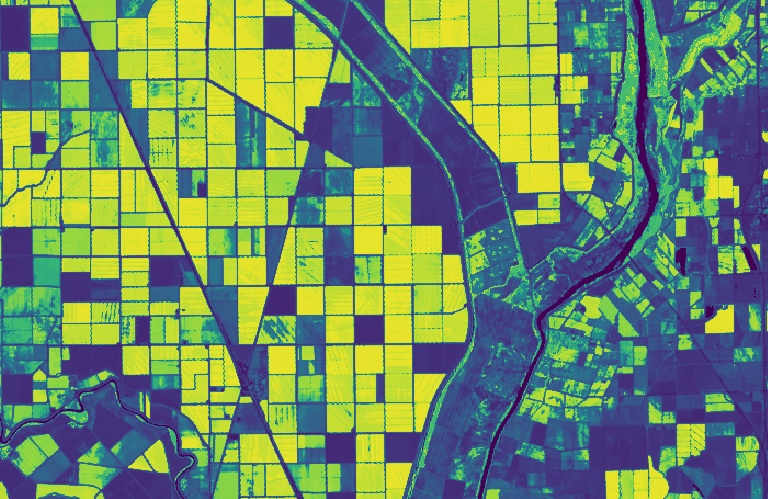

In [19]:
# Generate the LAI image
output_img = openet.lai.model.get_lai_image(
    prep_img, sensor=landsat_id.split('_')[0], nonveg=True,
)

image_url = (
    output_img.select(['LAI'])
    .getThumbURL({'min': 0, 'max': 4, 'palette': viridis, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

## Check the QA bands

In [21]:
# Input within range (0 in range, 1 out of range)
image_url = (
    output_img.select(['QA']).rightShift(0).bitwiseAnd(1)
    .getThumbURL({'min': 0, 'max': 1, 'palette': viridis, 'dimensions':image_size, 'region': region})
)
Image(url=image_url, embed=True, format='png')

HTTPError: HTTP Error 400: Bad Request

In [ ]:
# # Output within range (0 in range, 1 out of range)
# image_url = (
#     output_img.select(['QA']).rightShift(1).bitwiseAnd(1)
#     .getThumbURL({'min': 0, 'max': 8, 'palette': viridis, 'dimensions':image_size, 'region': region})
# )
# Image(url=image_url, embed=True, format='png')

In [ ]:
# # Biome (0 vegetation, 1 non-vegetation)
# image_url = (
#     output_img.select(['QA']).rightShift(2).bitwiseAnd(1)
#     .getThumbURL({'min': 0, 'max': 1, 'palette': viridis, 'dimensions':image_size, 'region': region})
# )
# Image(url=image_url, embed=True, format='png')